# FDN Reverberator - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: 10557065, MATR: 953546 )

In [121]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import scipy as sp
import IPython.display as ipd

In [ ]:
ipd.Image(filename = "images/FDNScheme.png")

## Params

In [ ]:
fs = 22050
N = 4
g = np.ones(N) # cambia come vuoi

t60 = 1 # reverberation time
# TODO: reverberation time should be function of frequency! from 0 to fs/2
K = 7
T=127
t60 = np.repeat(1.5, K) #! constant, need to create a graphic 'eq' to select t60
t60 = [1, 0.9, 1, 0.5, 0.4, 0.2, 0.1]
freqs = np.array([0, fs/(2*6), 2*fs/(2*6), 3*fs/(2*6), 4*fs/(2*6), 5*fs/(2*6), fs/2])
print(t60) 

# Min delay lenght
# TODO: create slider to select length (starting from min)
M_min = int(np.ceil(0.15*np.max(t60)*fs))
print(M_min)

In [ ]:
primeN = []

for num in range(2,101):
    prime = True
    for i in range(2,num):
        if (num%i==0):
            prime = False
    if prime:
       primeN.append(num)

M = []
for i in primeN:
    m = np.floor(0.5+np.log(M_min)/np.log(i))
    if i**m>M_min:
        M.append(int(i**m))

M = np.sort(M)

M = M[:N]

print(M)
# TODO: select numbers according to min desired length

## Lossless Feedback Matrix

Hadamard Matrix

In [ ]:
if((N & (N-1) == 0) and N != 0):
    Had = 1/np.sqrt(N)*sp.linalg.hadamard(N)
    print(Had)


Householder Matrix

In [ ]:
u = np.ones(N)
Hous = np.identity(N)-2/N*u*u.T
print(Hous)

In [122]:
# Case 3: Multiband filter design (preferred)
def multibandEqualizer(M_i, T, t60, freqs, fs):
    #for M_i in M:

        G_i = []
        # evaluate correct gains (one per band)
        for t60_f in t60:
            G_i.append(10**((-3*M_i)/(t60_f*fs))) 

        
        #print(G_i)

        taps = sp.signal.firwin2(numtaps=T, freq=freqs, gain=G_i, fs=fs)

        # w, h = sp.signal.freqz(taps, fs=fs)

        #plotFilter(w, h, M_i)

        return taps

In [ ]:
# #Circuit
# #Parameter initialization
# #U = [1, 0, 0, 0]

# U=np.append(np.sin(2*np.pi*440*np.arange(0,0.1,1/fs)),np.zeros(15000)) #sp.signal.unit_impulse(22050)
# B = [1,1,1,1]
# C = [1,1,1,1]
# G = [1,1,1,1]
# A = Hous
# '''                                          1 2 3 4
# #Delay lines data structure initialization   _ _ _ _  list of vectors
#                                              | | | |
#                                              | | | |
# '''
# delay_lines=[]

# for i in range(N):
#     delay_lines.append(np.zeros(M[i]))

# Output=[]
# for u in U: # For every sample of the input
#     delay_outputs = [] #Clear the list of delay outputs (N,)
#     x = []
#     for i in range(N): # For every circuit calculate output of delay lines and shift
#         delay_outputs.append(delay_lines[i][-1])
#         delay_lines[i][1:M[i]] = delay_lines[i][0:M[i]-1]
#         taps = multibandEqualizer(M[i], T, freqs, fs)
#         x.append(np.sum(np.multiply(taps, delay_lines[i][-T:])))
        

#     delay_outputs_array = np.asanyarray(x)
#     delay_output_mixed = np.dot(A,delay_outputs_array) # calculate feedback with the selected mixing matrix

#     Output.append(np.sum(np.multiply(delay_outputs_array, C)))# Calculate Output to E(z)

#     for i in range(N):
#         delay_lines[i][0] = B[i]*u + G[i] * delay_output_mixed[i] # insert the calculated input+feedback value into the first position of each delay line

# plt.figure()
# plt.plot(U)
# plt.plot(Output)

# print("Original")
# ipd.Audio(U, rate=fs)

In [ ]:
delay_lines[1][-T:].shape

In [ ]:
print("Filtered")
ipd.Audio(Output, rate=fs)



Once we have delayed the splitted signal, apply a filter (to each delay line). This filter is used to determine the $t_{60}$ of the reverb in each frequency band.

In [ ]:
def plotFilter(w, h, M_i):
        fig, ax1 = plt.subplots()
        ax1.set_title('Filter applied to delay line with M={}'.format(M_i))
        ax1.plot(w, 20 * np.log10(abs(h)), 'b')
        ax1.set_ylabel('Amplitude [dB]', color='b')
        ax1.set_xlabel('Frequency [rad/sample]')
        # ax2 = ax1.twinx()
        # angles = np.unwrap(np.angle(h))
        # ax2.plot(w, angles, 'g')
        # ax2.set_ylabel('Angle (radians)', color='g')
        # ax2.grid()
        # ax2.axis('tight')
        plt.show()

In [ ]:
# Case 1: Simple 1st order filter

def filter1st(x, M, t60, fs):
    for M_i in M:
        R_M = []
        # R_M = 1-(6.91*M_i/t60*fs)
        for t60_f in t60:
            R_M.append(10**((-3*M_i)/(t60_f*fs))) 
            
        print(R_M)

        # pole
        p_i = (R_M[0]-R_M[-1])/(R_M[0]+R_M[-1])

        # gain
        g_i = 2*(R_M[0]*R_M[-1])/(R_M[0]+R_M[-1])

        print(g_i, p_i)

        b = [0, g_i]
        a = [-p_i, 1]

        w, h = sp.signal.freqz(b,a, fs=fs)

        plotFilter(w, h, M_i)


In [ ]:
# Case 2: Orthogonalized 1st order delay filter
def ortFilter1st(x, M, t60, fs):
    for M_i in M:

        # gain
        g_i = 10**((-3*M_i)/(t60[0]*fs))

        # pole and zero
        p_i = np.log(10)/4 * np.log10(g_i) * (1-(1/(t60[-1]/t60[0])**2))

        print(g_i, p_i)

        b = [0, g_i*(1-p_i)]
        a = [-p_i, 1]

        w, h = sp.signal.freqz(b,a, fs=fs)

        plotFilter(w, h, M_i)


Spectral coloration equalizer

In [123]:
# coefficient of the filter:
def spectralEqualizer(t60, fs):
    b_coeff = (1-(t60[-1]/t60[0]))/(1+(t60[-1]/t60[0]))

    b = [1, -b_coeff]
    a = [1-b_coeff]

    return [a, b]

    # w, h = sp.signal.freqz(b,a, fs=fs)

    # fig, ax1 = plt.subplots()
    # ax1.set_title('Spectral Coloration Equalizer')
    # ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    # ax1.set_ylabel('Amplitude [dB]', color='b')
    # ax1.set_xlabel('Frequency [rad/sample]')
    # # ax2 = ax1.twinx()
    # # angles = np.unwrap(np.angle(h))
    # # ax2.plot(w, angles, 'g')
    # # ax2.set_ylabel('Angle (radians)', color='g')
    # # ax2.grid()
    # # ax2.axis('tight')
    # plt.show()

# Main:

In [190]:
# test signal

fs = 22050
signal = np.append(0.5*np.sin(2*np.pi*440*np.arange(0,0.1,1/fs)),np.zeros(15000)) #sp.signal.unit_impulse(22050)


In [191]:
# parameters


N = 4 # number of parallel delay lines

# weight coefficients (default to 1)
g = np.ones(N)
b = np.ones(N)
c = np.ones(N)

# reverberation time should be function of frequency, from 0 to fs/2
T=7 # filter taps
t60 = [1, 0.9, 0.7, 0.5, 0.4, 0.2, 0.1]
freqs = np.array([0, fs/(2*6), 2*fs/(2*6), 3*fs/(2*6), 4*fs/(2*6), 5*fs/(2*6), fs/2])
print('Frequency bands {0} & relative reverberation times {1}'.format(freqs, t60)) 

# Delay lenghts
# TODO: create slider to select length (starting from min)
M_min = int(np.ceil(0.15*np.max(t60)*fs))

primeN = []

# generate some prime numbers...
for num in range(2,101):
    prime = True
    for i in range(2,num):
        if (num%i==0):
            prime = False
    if prime:
       primeN.append(num)

# compute M starting from (different) prime numbers
M = []
for i in primeN:
    m = np.floor(0.5+np.log(M_min)/np.log(i))
    if i**m>M_min:
        M.append(int(i**m))

M = np.sort(M)

M = M[:N]

print('Selected delay lengths:',M)
# TODO: select numbers according to min desired length


Frequency bands [    0.   1837.5  3675.   5512.5  7350.   9187.5 11025. ] & relative reverberation times [1, 0.9, 0.7, 0.5, 0.4, 0.2, 0.1]
Selected delay lengths: [3481 3721 4096 4489]


In [192]:
# feedback matrices

# hadamard
if((N & (N-1) == 0) and N != 0):
    Had = 1/np.sqrt(N)*sp.linalg.hadamard(N)

#householder
u = np.ones(N)
Hous = np.identity(N)-2/N*u*u.T

In [193]:
sig = np.append(signal, np.zeros(5*np.max(M)))

output = np.zeros(sig.size)

B = np.ones(N)
C = np.ones(N)
G = [0.5, 0.5, 0.5, 0.5]
d = 0.5

bufferSize = np.max(M) + 128
taps = np.zeros((N,T))


for i in range(N):
    taps[i] = multibandEqualizer(M[i], T, t60, freqs, fs)


y = np.zeros(N).T
mix = np.zeros(N).T
filtered = np.zeros(N).T
x = np.zeros(N).T
out = np.zeros((N,np.max(M)+sig.size))

writeIndex = M
readIndex = bufferSize-M
filterIndex = readIndex
buffer = np.zeros((N, bufferSize))
j = 0    

for sample in sig:

    for i in range(N): # do it for every delay line (in //)

        # read the samples from the buffers
        y[i] = buffer[i][readIndex[i]]
        # extract output
        out[i][j] = C[i]*y[i]
        
        # now mix up signals by applying feedback matrix (Q)
        mix[i] = np.sum(y[i]*Had[i][:])

        # filter the signals (g)
        filterIndex[i] = readIndex[i] # forse non serve vettore
        filtered[i] = y[i]

        for tap in taps[i]:
            filtered[i] += buffer[i][filterIndex[i]]*tap
            filterIndex[i] = filterIndex[i] -1
            if filterIndex[i]<0:
                filterIndex[i] = bufferSize-1


        # new signal to be processed (input+feedback)
        x[i] = B[i]*sample + filtered[i]*G[i]

        # update buffer by writing new sample in correct position (delay)
        buffer[i][writeIndex[i]] = x[i]

        # check if indices of the circular buffer are ok
        readIndex[i] = readIndex[i] + 1
        if readIndex[i]>=bufferSize:
            readIndex[i] = 0

        writeIndex[i] = writeIndex[i] + 1
        if writeIndex[i]>=bufferSize:
            writeIndex[i] = 0
    
    j = j+1



In [194]:
# tone equalization filter

a, b = spectralEqualizer(t60, fs)
output = sp.signal.lfilter(a, b, np.sum(out, axis= 0))
print(np.sum(out[:][:], axis= 0))

# final result
sig = np.append(signal, np.zeros(output.size-signal.size))
output = output + sig*d


[0. 0. 0. ... 0. 0. 0.]


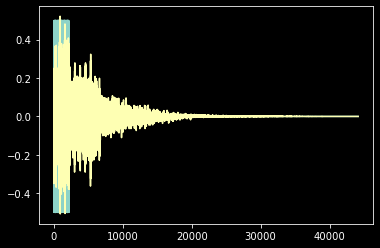

In [195]:
plt.plot(sig)
plt.plot(output)
ipd.display(ipd.Audio(output, rate=fs))

